# Model demo

In [32]:
# import libraries
from tensorflow.keras import models, preprocessing, applications
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
# set max column width
pd.set_option('display.max_colwidth', None)

### Set up test data

In [25]:
# create path to data
data_dir_test20 = os.path.dirname(os.getcwd()) + '\\data\\images-model\\test20\\'
# create a varaible to contain the normalizer
test_datagen = image.ImageDataGenerator(rescale=1./255)
# create a testing dataset from the pre-processed images
test_gen = test_datagen.flow_from_directory(
    data_dir_test20,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    seed = 42)

Found 1082 images belonging to 2 classes.


In [26]:
# get the location of the files in the test dataset
filepaths = test_gen.filenames
# get the labels of the files in the test dataset
test_labels = test_gen.classes
# confirm the order of the classes
class_names = test_gen.class_indices

In [35]:
class_names = {'instrument': 0, 'no-instrument': 1}

### Set up demo data

In [3]:
# create path to data
demo = os.path.dirname(os.getcwd()) + '\\data\\test\\processed\\'

In [4]:
# set parameters for the model
batch_size = 32
img_height = 558
img_width = 558

In [5]:
# create a variable to contain the normalizer
demo_datagen = image.ImageDataGenerator(rescale=1/255.)

# normalize the demo data
demo_ds = demo_datagen.flow_from_directory(
                        demo,
                        target_size = (img_height, img_width),
                        classes = None,
                        class_mode=None,
                        shuffle=False)

Found 242 images belonging to 1 classes.


In [6]:
# write out the demo data filenames
demo_ds_fp = demo_ds.filenames
demo_ds_fp = [os.path.dirname(os.getcwd()) + '\\data\\test\\processed\\' + x for x in demo_ds_fp]

### Set up models

In [7]:
# Define a function for the model
def create_model():
    # instantiate the base model, using pretrained weights from imagenet
    # note that if this does not run, downgrade h5py
    # pip install "h5py==2.10.0" --force-reinstall
    base_model = applications.InceptionV3(weights = 'imagenet',
                                          include_top=False,
                                          input_shape = (img_height, img_width, 3))
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and add a logistic layer -- output should be the number of classes (in this case, 2)
    predictions = Dense(2, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # freeze the first 249 layers and unfreeze the rest:
    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics = ['BinaryAccuracy',
                            'FalseNegatives',
                            'FalsePositives',
                            'TrueNegatives',
                            'TruePositives',
                            'AUC',
                            'Precision',
                            'Recall'])

    return model

In [8]:
# Create a basic model instance
model_a = create_model()
model_b = create_model()

#### Load model weights

In [11]:
# model_a is based on minimal image augmentation on the training data, captured at epoch 10
model_a.load_weights('model_checkpoints/training_05-minimal-aug/cp-10.ckpt')

In [10]:
# model_b is based on maximal image augmentation on the training data, captured at epoch 10
model_b.load_weights('model_checkpoints/training_05-max-aug/cp-10.ckpt')

### Evaluate the models

In [27]:
# predict the probability of instrument / no-instrument label of the test images
test_predictions_a = model_a.predict(test_gen)
test_predictions_b = model_b.predict(test_gen)

In [28]:
# convert the probabilities into a binary class prediction
# adjust the threshold as needed to optimize for precision / recall
# N.B. the threshold is set based on probability of a `no-kithara` label
predicted_class_a = (test_predictions_a[:,1]>=0.95).astype(int)
print(predicted_class_a)

predicted_class_b = (test_predictions_b[:,1]>=0.95).astype(int)
print(predicted_class_b)

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [36]:
# print the AUC for the model
print('model_a AUC:')
print(roc_auc_score(test_labels, test_predictions_a[:,1]))
print('model_b AUC:')
print(roc_auc_score(test_labels, test_predictions_b[:,1]))

# print the overall classification report with precision, recall, accuracy, and f1-scores
print('model_a report:')
print(classification_report(test_labels, predicted_class_a, target_names = class_names))
print('model_b report:')
print(classification_report(test_labels, predicted_class_b, target_names = class_names))

model_a AUC:
0.9994451219512195
model_b AUC:
0.9963780487804877
model_a report:
               precision    recall  f1-score   support

   instrument       0.99      0.93      0.96        82
no-instrument       0.99      1.00      1.00      1000

     accuracy                           0.99      1082
    macro avg       0.99      0.96      0.98      1082
 weighted avg       0.99      0.99      0.99      1082

model_b report:
               precision    recall  f1-score   support

   instrument       0.69      0.96      0.81        82
no-instrument       1.00      0.96      0.98      1000

     accuracy                           0.96      1082
    macro avg       0.84      0.96      0.89      1082
 weighted avg       0.97      0.96      0.97      1082



### Generate predictions from the models

In [12]:
# write out the demo predictions
demo_predictions_a = model_a.predict(demo_ds)
demo_predictions_b = model_b.predict(demo_ds)

In [13]:
pred_a = pd.DataFrame({'filepath': demo_ds_fp, 'predictions': demo_predictions_a[:,0]}).sort_values('predictions')
pred_b = pd.DataFrame({'filepath': demo_ds_fp, 'predictions': demo_predictions_b[:,0]}).sort_values('predictions')

In [29]:
instruments_a = pred_a[pred_a['predictions'] >= 0.05]
instruments_b = pred_b[pred_b['predictions'] >= 0.05]

In [30]:
instruments_a

,filepath,predictions
155,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\test\processed\demo\MANN_81666-79-1482-429.jpg,0.947137


In [15]:
# model_a predictions for chordophones
print(pred_a[pred_a['filepath'].str.contains('103-765-357')])
print(pred_a[pred_a['filepath'].str.contains('103-867-357')])
print(pred_a[pred_a['filepath'].str.contains('103-867-408')])
print(pred_a[pred_a['filepath'].str.contains('103-918-357')])
# model_b predictions for chordophones
print(pred_b[pred_b['filepath'].str.contains('103-765-357')])
print(pred_b[pred_b['filepath'].str.contains('103-867-357')])
print(pred_b[pred_b['filepath'].str.contains('103-867-408')])
print(pred_b[pred_b['filepath'].str.contains('103-918-357')])

                                                                                                                filepath  \
56  C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\test\processed\demo\MANN_81666-103-765-357.jpg   

     predictions  
56  1.023451e-26  
                                                                                                                filepath  \
57  C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\test\processed\demo\MANN_81666-103-867-357.jpg   

    predictions  
57     0.007775  
                                                                                                                filepath  \
58  C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\test\processed\demo\MANN_81666-103-867-408.jpg   

     predictions  
58  1.224244e-09  
                                                                                                                filepath  \
62  C:\Users\Vero

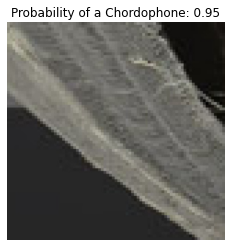

In [17]:
for index, row in instruments_a.iterrows():
    img = Image.open(instruments_a['filepath'][index])
    prob = instruments_a['predictions'][index]
    plt.title('Probability of a Chordophone: %0.2f' %prob)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

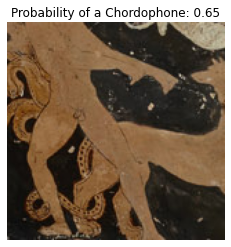

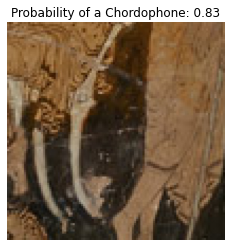

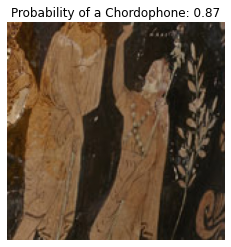

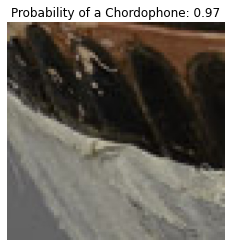

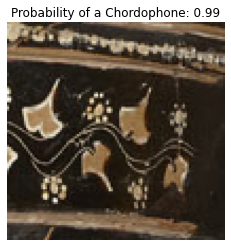

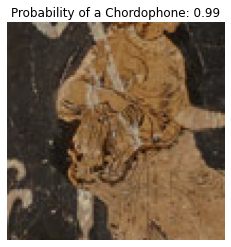

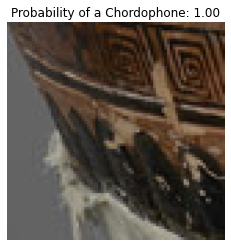

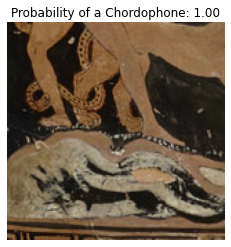

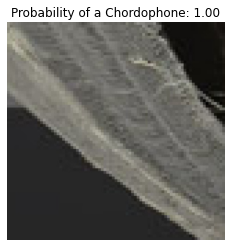

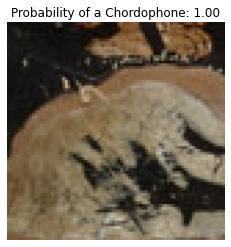

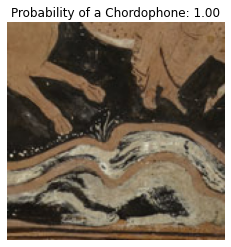

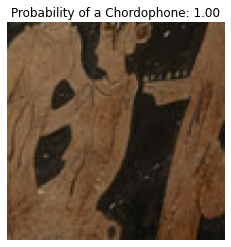

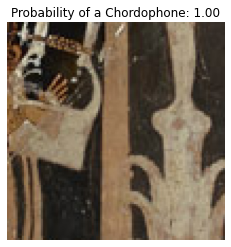

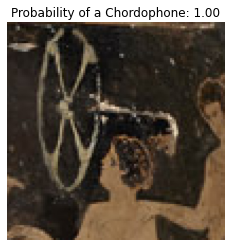

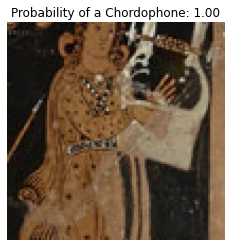

In [18]:
for index, row in instruments_b.iterrows():
    img = Image.open(instruments_b['filepath'][index])
    prob = instruments_b['predictions'][index]
    plt.title('Probability of a Chordophone: %0.2f' %prob)
    plt.imshow(img)
    plt.axis('off')
    plt.show()